In [3]:
import numpy as np
import pandas as pd
import os.path as op
import os
from os import walk
import datetime
import time

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import f1_score, recall_score, precision_score

torch.manual_seed(42)
tb = SummaryWriter()

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}

In [5]:
year = 2017
images = np.memmap(
    op.join("./monthly_20d/monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"),
    dtype=np.uint8,
    mode="r",
).reshape((-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))

In [7]:
label_df = pd.read_feather(
    op.join("./monthly_20d/monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather")
)
assert len(label_df) == len(images)
label_df.head()

,Date,StockID,MarketCap,Ret_5d,Ret_20d,Ret_60d,Ret_month,EWMA_vol
0,2017-01-31,10001,133078.0,4.370390e-07,-0.000002,-0.005954,-0.000002,0.000450
1,2017-02-28,10001,133078.0,3.951997e-03,0.002795,0.009953,0.009953,0.000180
2,2017-03-31,10001,133604.0,-7.874612e-03,-0.015749,0.021723,-0.015749,0.000064
3,2017-04-28,10001,131500.0,9.999880e-03,0.016001,0.038072,0.016001,0.000030
4,2017-05-31,10001,133604.0,4.370390e-07,0.021722,NaN,0.023703,0.000015


## Changing the parameters

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                1,
                64,
                kernel_size=(5, 3),
                stride=(3, 1),
                dilation=(2, 1),
                padding=(12, 1),
            ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                64,
                128,
                kernel_size=(5, 3),
                stride=(3, 1),
                dilation=(2, 1),
                padding=(12, 1),
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(
                128,
                256,
                kernel_size=(5, 3),
                stride=(3, 1),
                dilation=(2, 1),
                padding=(12, 1),
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(46080, 2),
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.reshape(-1, 1, 64, 60)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.reshape(-1, 46080)
        x = self.fc1(x)
        x = self.softmax(x)
        return x

### Model 2
Increase Kernel Size

In [10]:
class Neta(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1a = nn.Sequential(
            nn.Conv2d(
                1,
                64,
                kernel_size=(7, 5), # Increased kernel size to (7, 5)
                stride=(3, 1),
                dilation=(2, 1),
                padding=(12, 1),
            ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer2a = nn.Sequential(
            nn.Conv2d(
                64,
                128,
                kernel_size=(7, 5), # Increased kernel size to (7, 5)
                stride=(3, 1),
                dilation=(2, 1),
                padding=(12, 1),
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer3a = nn.Sequential(
            nn.Conv2d(
                128,
                256,
                kernel_size=(7, 5), # Increased kernel size to (7, 5)
                stride=(3, 1),
                dilation=(2, 1),
                padding=(12, 1),
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.fc1a = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(46080, 2),
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.reshape(-1, 1, 64, 60)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.reshape(-1, 46080)
        x = self.fc1(x)
        x = self.softmax(x)
        return x

### Model 3
Decreased Kernel Size

In [11]:

class Netb(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1b = nn.Sequential(
            nn.Conv2d(
                1,
                64,
                kernel_size=(3, 3), # Decreased kernel size to (3, 3)
                stride=(3, 1),
                dilation=(2, 1),
                padding=(12, 1),
            ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer2b = nn.Sequential(
            nn.Conv2d(
                64,
                128,
                kernel_size=(3, 3), # Decreased kernel size to (3, 3)
                stride=(3, 1),
                dilation=(2, 1),
                padding=(12, 1),
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer3b = nn.Sequential(
            nn.Conv2d(
                128,
                256,
                kernel_size=(3, 3), # Decreased kernel size to (3, 3)
                stride=(3, 1),
                dilation=(2, 1),
                padding=(12, 1),
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(46080, 2),
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.reshape(-1, 1, 64, 60)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.reshape(-1, 46080)
        x = self.fc1(x)
        x = self.softmax(x)
        return x

### Model 4
Increased Neagtive Slope of Leaky ReLU

In [12]:
class Netc(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1c = nn.Sequential(
            nn.Conv2d(
                1,
                64,
                kernel_size=(5, 3),
                stride=(3, 1),
                dilation=(2, 1),
                padding=(12, 1),
            ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer2c = nn.Sequential(
            nn.Conv2d(
                64,
                128,
                kernel_size=(5, 3),
                stride=(3, 1),
                dilation=(2, 1),
                padding=(12, 1),
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.05, inplace=True), # Increased negative slope from 0.01 to 0.05
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer3c = nn.Sequential(
            nn.Conv2d(
                128,
                256,
                kernel_size=(5, 3),
                stride=(3, 1),
                dilation=(2, 1),
                padding=(12, 1),
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.05, inplace=True), # Increased negative slope from 0.01 to 0.05
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.fc1c = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(46080, 2),
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.reshape(-1, 1, 64, 60)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.reshape(-1, 46080)
        x = self.fc1(x)
        x = self.softmax(x)
        return x

### Model 5
Decreased Negative Slope of Leaky ReLU

In [13]:
class Netd(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1d = nn.Sequential(
            nn.Conv2d(
                1,
                64,
                kernel_size=(5, 3),
                stride=(3, 1),
                dilation=(2, 1),
                padding=(12, 1),
            ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer2d = nn.Sequential(
            nn.Conv2d(
                64,
                128,
                kernel_size=(5, 3),
                stride=(3, 1),
                dilation=(2, 1),
                padding=(12, 1),
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.005, inplace=True), # Decreased negative slope to 0.005
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer3d = nn.Sequential(
            nn.Conv2d(
                128,
                256,
                kernel_size=(5, 3),
                stride=(3, 1),
                dilation=(2, 1),
                padding=(12, 1),
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.005, inplace=True), # Decreased negative slope to 0.005
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.fc1d = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(46080, 2),
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.reshape(-1, 1, 64, 60)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.reshape(-1, 46080)
        x = self.fc1(x)
        x = self.softmax(x)
        return x

In [14]:
x = torch.Tensor(images[42].copy())
x = x.reshape(-1, 1, 64, 60)
x.requires_grad = True
baseline = torch.zeros_like(x)

0


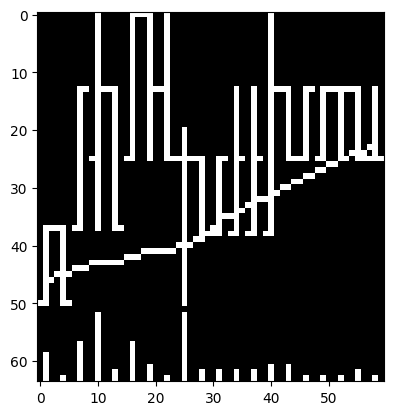

1


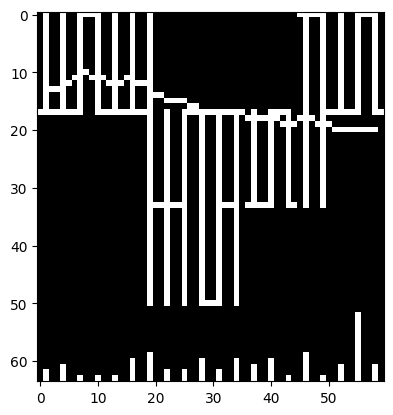

2


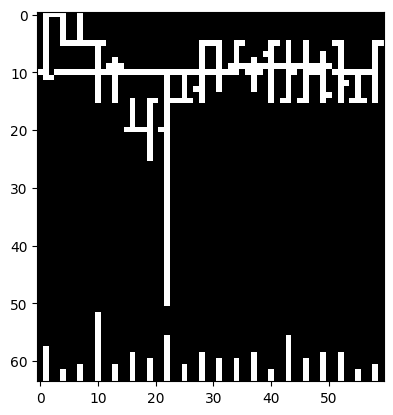

3


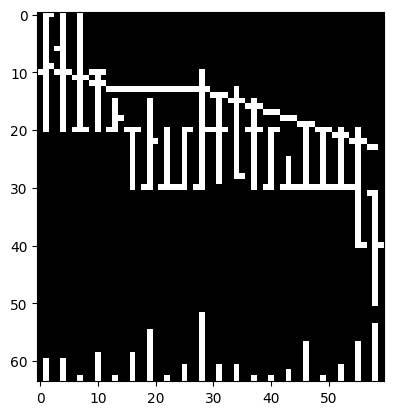

4


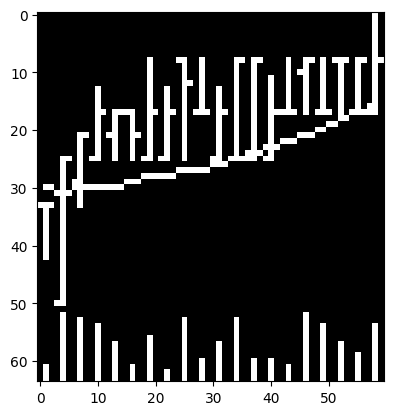

In [15]:
import matplotlib.pyplot as plt

for i in range(5):
    print(i)
    plt.imshow(images[i], cmap="gray")
    plt.show()

In [16]:
label_df.head()

,Date,StockID,MarketCap,Ret_5d,Ret_20d,Ret_60d,Ret_month,EWMA_vol
0,2017-01-31,10001,133078.0,4.370390e-07,-0.000002,-0.005954,-0.000002,0.000450
1,2017-02-28,10001,133078.0,3.951997e-03,0.002795,0.009953,0.009953,0.000180
2,2017-03-31,10001,133604.0,-7.874612e-03,-0.015749,0.021723,-0.015749,0.000064
3,2017-04-28,10001,131500.0,9.999880e-03,0.016001,0.038072,0.016001,0.000030
4,2017-05-31,10001,133604.0,4.370390e-07,0.021722,NaN,0.023703,0.000015


In [17]:
year_list = np.arange(1993, 2014, 1)

images = []
label_df = []
for year in year_list:
    images.append(
        np.memmap(
            op.join("./monthly_20d/monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"),
            dtype=np.uint8,
            mode="r",
        ).reshape((-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))
    )
    label_df.append(
        pd.read_feather(
            op.join(
                "./monthly_20d/monthly_20d",
                f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather",
            )
        )
    )

images = np.concatenate(images)
label_df = pd.concat(label_df)

print(images.shape)
print(label_df.shape)

(1787748, 64, 60)
(1787748, 8)


In [18]:
class MyDataset(Dataset):

    def __init__(self, img, label):
        self.img = torch.Tensor(img.copy())
        self.label = torch.Tensor(label)
        self.len = len(img)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.img[idx], self.label[idx]

In [19]:
use_gpu = True
use_random_split = False
use_dataparallel = True

if not use_random_split:
    train_val_ratio = 0.7
    split_idx = int(images.shape[0] * 0.7)
    train_dataset = MyDataset(
        images[:split_idx], (label_df.Ret_5d > 0).values[:split_idx]
    )
    val_dataset = MyDataset(
        images[split_idx:], (label_df.Ret_5d > 0).values[split_idx:]
    )
else:
    dataset = MyDataset(images, (label_df.Ret_5d > 0).values)
    train_val_ratio = 0.7
    train_dataset, val_dataset = random_split(
        dataset,
        [
            int(dataset.len * train_val_ratio),
            dataset.len - int(dataset.len * train_val_ratio),
        ],
        generator=torch.Generator().manual_seed(42),
    )
    del dataset

train_dataloader = DataLoader(
    train_dataset, batch_size=128, shuffle=True, pin_memory=True
)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True, pin_memory=True)

In [20]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0)
    elif isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)

In [23]:
import torch
print(torch.__version__)
print(torch.version.cuda)


2.6.0+cpu
None


In [26]:
assert torch.cuda.is_available() and use_gpu, "CUDA is not available or use_gpu is False!"
device = "cuda"
export_onnx = True
net = Net().to(device)
net.apply(init_weights)

if export_onnx:
    import torch.onnx

    x = torch.randn([1, 1, 64, 60]).to(device)
    torch.onnx.export(
        net,
        x,
        "./cnn_baseline.onnx",
        export_params=False,
        opset_version=10,
        do_constant_folding=False,
        input_names=["input_images"],
        output_names=["output_prob"],
        dynamic_axes={
            "input_images": {0: "batch_size"},
            "output_prob": {0: "batch_size"},
        },
    )

AssertionError: CUDA is not available or use_gpu is False!

In [24]:
count = 0
for names, parameters in net.named_parameters():
    print(names, parameters.size())
    count += parameters.numel()
print("total_parameters: {}".format(count))

NameError: name 'net' is not defined

In [ ]:
def train_loop(dataloader, net, loss_fn, optimizer):

    running_loss = 0.0
    current = 0
    net.train()

    with tqdm(dataloader) as t:
        for batch, (X, y) in enumerate(t):
            X = X.to(device)
            y = y.to(device)
            y_pred = net(X)
            loss = loss_fn(y_pred, y.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss = (len(X) * loss.item() + running_loss * current) / (
                len(X) + current
            )
            current += len(X)
            t.set_postfix({"running_loss": running_loss})

    return running_loss

In [ ]:
def val_loop(dataloader, net, loss_fn):
    running_loss = 0.0
    current = 0
    net.eval()

    with torch.no_grad():
        with tqdm(dataloader) as t:
            for batch, (X, y) in enumerate(t):
                X = X.to(device)
                y = y.to(device)
                y_pred = net(X)
                loss = loss_fn(y_pred, y.long())

                running_loss += loss.item()
                running_loss = (len(X) * running_loss + loss.item() * current) / (
                    len(X) + current
                )
                current += len(X)
                t.set_postfix({"running_loss": running_loss})

    return running_loss

In [ ]:
if use_gpu and use_dataparallel and "DataParallel" not in str(type(net)):
    net = net.to(device)
    net = nn.DataParallel(net)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5)

start_epoch = 0
min_val_loss = 1e9
last_min_ind = -1
early_stopping_epoch = 5

In [ ]:
# Before your training loop, create lists to store the loss values
train_losses = []
val_losses = []

# Modify the main training loop
start_time = datetime.datetime.now().strftime("%Y%m%d_%H:%M:%S")
directory_path = "./pt/{}".format(start_time.replace(":", "-"))
os.makedirs(directory_path)

epochs = 100
for t in range(start_epoch, epochs):
    print(f"Epoch {t}\n-------------------------------")
    time.sleep(0.2)
    train_loss = train_loop(train_dataloader, net, loss_fn, optimizer)
    val_loss = val_loop(val_dataloader, net, loss_fn)

    # Append the losses to our tracking lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # The rest of your existing code
    tb.add_histogram("train_loss", train_loss, t)
    torch.save(
        net,
        "./pt"
        + os.sep
        + start_time.replace(":", "-")
        + os.sep
        + "baseline_epoch_{}_train_{:5f}_val_{:5f}.pt".format(t, train_loss, val_loss),
    )
    if val_loss < min_val_loss:
        last_min_ind = t
        min_val_loss = val_loss
        min_val_loss_path = './pt/{}'.format(start_time.replace(":", "-"))
    elif t - last_min_ind >= early_stopping_epoch:
        break

print("Done!")
print("Best epoch: {}, val_loss: {}".format(last_min_ind, min_val_loss))



In [ ]:
# Add this after the training loop to create the visualization
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid(True)
plt.savefig(f"{directory_path}/loss_curve.png")  # Save the figure to the same directory as model checkpoints
plt.show()

## Testing

In [ ]:
year_list = np.arange(2015, 2019, 1)

images = []
label_df = []

for year in year_list:
    images.append(
        np.memmap(
            op.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"),
            dtype=np.uint8,
            mode="r",
        ).reshape((-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))
    )
    label_df.append(
        pd.read_feather(
            op.join(
                "./monthly_20d",
                f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather",
            )
        )
    )

images = np.concatenate(images)
label_df = pd.concat(label_df)

print(images.shape)
print(label_df.shape)

In [ ]:
dataset = MyDataset(images, (label_df.Ret_5d > 0).values)
test_dataloader = DataLoader(dataset, batch_size=2048, shuffle=False)

In [ ]:
net_path = "pt/20250325_11-56-14/baseline_epoch_3_train_0.688597_val_0.611354.pt"
net = torch.load(net_path, weights_only=False)

In [ ]:
def eval_loop(dataloader, net, loss_fn):

    running_loss = 0.0
    total_loss = 0.0
    current = 0
    net.eval()
    target = []
    predict = []
    with torch.no_grad():
        with tqdm(dataloader) as t:
            for batch, (X, y) in enumerate(t):
                X = X.to(device)
                y = y.to(device)
                y_pred = net(X)
                target.append(y.detach())
                predict.append(y_pred.detach())
                loss = loss_fn(y_pred, y.long())

                running_loss = (len(X) * loss.item() + running_loss * current) / (
                    len(X) + current
                )
                current += len(X)
                t.set_postfix({"running_loss": running_loss})

    return total_loss, torch.cat(predict), torch.cat(target)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
test_loss, y_pred, y_target = eval_loop(test_dataloader, net, loss_fn)

predict_logit = (torch.nn.Softmax(dim=1)(y_pred)[:, 1]).cpu().numpy()

In [ ]:
# Calculate the percentage of target predicted above 0.5
predictions = (predict_logit > 0.5).sum()
total = len(predict_logit)
accuracy = (predictions / total) * 100

print(f"Test Accuracy: {accuracy:.2f}%")

In [ ]:
# Convert predictions to binary
binary_predictions = (predict_logit > 0.5).astype(int)
binary_targets = y_target.cpu().numpy()

# Calculate F1 score, recall, and precision
f1 = f1_score(binary_targets, binary_predictions)
recall = recall_score(binary_targets, binary_predictions)
precision = precision_score(binary_targets, binary_predictions)

print(f"F1 Score: {f1:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")

In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(binary_targets, binary_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted Negative", "Predicted Positive"],
    yticklabels=["Actual Negative", "Actual Positive"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Testing with Different Parameter Tuning

In [ ]:
def build_net(kernel_size=(5, 3), negative_slope=(0.1, 0.01)):
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.layer1 = nn.Sequential(
                nn.Conv2d(1, 64, kernel_size=kernel_size, stride=(3, 1), dilation=(2, 1), padding=(12, 1)),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(negative_slope=negative_slope[0], inplace=True),
                nn.MaxPool2d((2, 1), stride=(2, 1)),
            )
            self.layer2 = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=kernel_size, stride=(3, 1), dilation=(2, 1), padding=(12, 1)),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(negative_slope=negative_slope[1], inplace=True),
                nn.MaxPool2d((2, 1), stride=(2, 1)),
            )
            self.layer3 = nn.Sequential(
                nn.Conv2d(128, 256, kernel_size=kernel_size, stride=(3, 1), dilation=(2, 1), padding=(12, 1)),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(negative_slope=negative_slope[1], inplace=True),
                nn.MaxPool2d((2, 1), stride=(2, 1)),
            )
            self.fc1 = nn.Sequential(
                nn.Dropout(p=0.5),
                nn.Linear(46080, 2),
            )
            self.softmax = nn.Softmax(dim=1)

        def forward(self, x):
            x = x.reshape(-1, 1, 64, 60)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = x.reshape(-1, 46080)
            x = self.fc1(x)
            x = self.softmax(x)
            return x
    return Net()

### Loopocre Configuration for Testing Models

In [ ]:
model_configs = {
    "larger_kernel": {"kernel_size": (7, 5), "negative_slope": (0.1, 0.01)},
    "smaller_kernel": {"kernel_size": (3, 3), "negative_slope": (0.1, 0.01)},
    "increased_slope": {"kernel_size": (5, 3), "negative_slope": (0.1, 0.05)},
    "decreased_slope": {"kernel_size": (5, 3), "negative_slope": (0.1, 0.005)},
}

### Training Loop Configuration

In [ ]:
def train_and_evaluate(config_name, config, train_loader, val_loader, test_loader):
    net = build_net(config["kernel_size"], config["negative_slope"]).to(device)
    net.apply(init_weights)

    if use_gpu and use_dataparallel and "DataParallel" not in str(type(net)):
        net = nn.DataParallel(net)

    optimizer = torch.optim.Adam(net.parameters(), lr=1e-5)
    loss_fn = nn.CrossEntropyLoss()

    # Setup paths
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    directory = f"./pt/{timestamp}_{config_name}"
    os.makedirs(directory, exist_ok=True)

    # Training
    train_losses, val_losses = [], []
    min_val_loss = float("inf")
    last_min_ind = 0

    for epoch in range(epochs):
        print(f"[{config_name}] Epoch {epoch}")
        train_loss = train_loop(train_loader, net, loss_fn, optimizer)
        val_loss = val_loop(val_loader, net, loss_fn)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Save model
        model_path = f"{directory}/epoch_{epoch}_train_{train_loss:.4f}_val_{val_loss:.4f}.pt"
        torch.save(net, model_path)

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            last_min_ind = epoch
            best_model_path = model_path
        elif epoch - last_min_ind >= early_stopping_epoch:
            break

    # Plot Loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.legend()
    plt.title(f"Loss Curve - {config_name}")
    plt.savefig(f"{directory}/loss_curve.png")
    plt.close()

    # Load best model
    best_model = torch.load(best_model_path)

    # Test Evaluation
    test_loss, y_pred, y_target = eval_loop(test_loader, best_model, loss_fn)
    predict_logit = torch.nn.Softmax(dim=1)(y_pred)[:, 1].cpu().numpy()
    binary_predictions = (predict_logit > 0.5).astype(int)
    binary_targets = y_target.cpu().numpy()

    # Metrics
    f1 = f1_score(binary_targets, binary_predictions)
    recall = recall_score(binary_targets, binary_predictions)
    precision = precision_score(binary_targets, binary_predictions)
    accuracy = (binary_predictions == binary_targets).mean()

    print(f"[{config_name}] Test Accuracy: {accuracy:.2%}, F1: {f1:.2f}, Recall: {recall:.2f}, Precision: {precision:.2f}")

    return {
        "config": config_name,
        "accuracy": accuracy,
        "f1": f1,
        "recall": recall,
        "precision": precision,
        "loss_curve_path": f"{directory}/loss_curve.png",
        "model_path": best_model_path,
    }